/Users/sumitchand/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/yt/w26mrk4n2njgbd9ykmtx20cr0000gn/T/ipykernel_3279/3820966612.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch shou

Population-Weighted PM2.5 Exposure: 184.29 µg/m³


ERROR 1: PROJ: internal_proj_create_from_database: /Users/sumitchand/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


CRSError: The WKT could not be parsed. OGR Error code 6

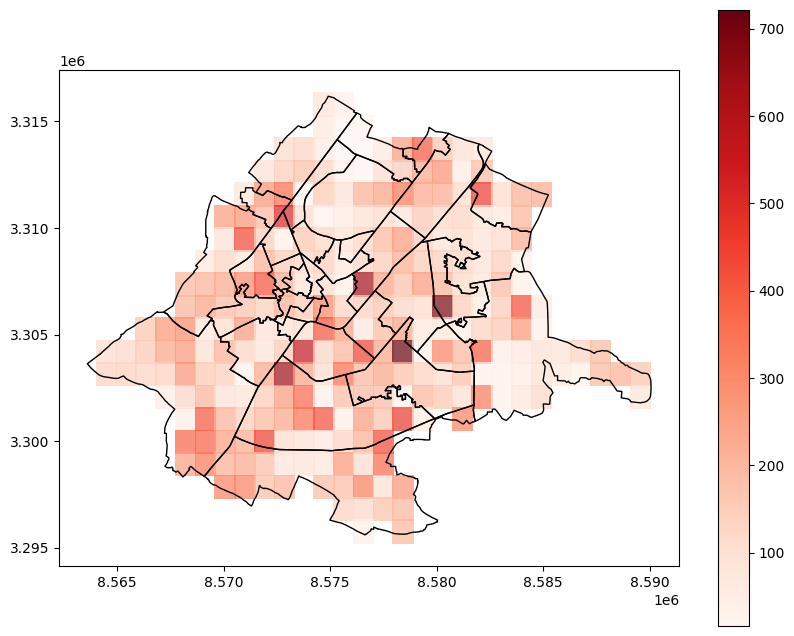

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from rasterio.transform import xy
from scipy.spatial import cKDTree
import contextily as ctx


def load_raster(tif_path):
    """Load raster data and return array and metadata."""
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        transform = src.transform
        crs = src.crs
    return data, transform, crs


def load_shapefile(shp_path):
    """Load shapefile as a GeoDataFrame."""
    return gpd.read_file(shp_path)


def reproject_shapefile(gdf, target_crs):
    """Reproject shapefile to match the target CRS."""
    if gdf.crs != target_crs:
        return gdf.to_crs(target_crs)
    return gdf


def clip_raster(tif_path, shp_gdf, output_path):
    """Clip raster using a shapefile and save the output."""
    geom = [feature["geometry"] for feature in shp_gdf.__geo_interface__["features"]]
    with rasterio.open(tif_path) as src:
        clipped_data, clipped_transform = rasterio.mask.mask(src, geom, crop=True)
        clipped_meta = src.meta.copy()
    
    clipped_meta.update({
        "height": clipped_data.shape[1],
        "width": clipped_data.shape[2],
        "transform": clipped_transform
    })
    
    with rasterio.open(output_path, "w", **clipped_meta) as dest:
        dest.write(clipped_data)
    
    return clipped_data, clipped_transform


def extract_population_data(clipped_data, clipped_transform):
    """Extract non-zero population values into a DataFrame."""
    rows, cols = np.where(clipped_data[0] > 0)
    xs, ys = rasterio.transform.xy(clipped_transform, rows, cols)
    return pd.DataFrame({"Longitude": xs, "Latitude": ys, "Population": clipped_data[0][rows, cols]})


def load_sensor_data(static_path, dynamic_path):
    """Load and combine static and dynamic sensor data."""
    df_static = pd.read_csv(static_path, parse_dates=["data_created_time"])
    df_dynamic = pd.read_csv(dynamic_path, parse_dates=["data_created_time"])
    df = pd.concat([df_static, df_dynamic], ignore_index=True)
    df["hour"] = df["data_created_time"].dt.floor("H")
    df_agg = df.groupby(["hour", "lat", "long"]).agg({"pm_25": "mean"}).reset_index()
    df_agg["hour"] = pd.to_datetime(df_agg["hour"]).dt.tz_localize(None)
    df_agg["pm_25"].interpolate(method="linear", inplace=True)
    return df_agg


def interpolate_pm25(df_agg, df_grid):
    """Perform IDW interpolation to estimate PM2.5 values on a 1km grid."""
    lcs_points = np.array(list(zip(df_agg["lat"], df_agg["long"])))
    lcs_pm25 = df_agg["pm_25"].values
    grid_points = np.array(list(zip(df_grid["Latitude"], df_grid["Longitude"])))
    tree = cKDTree(lcs_points)
    distances, indices = tree.query(grid_points, k=5)
    weights = 1 / (distances + 1e-5)
    weights /= weights.sum(axis=1, keepdims=True)
    df_grid["PM2.5"] = np.sum(weights * lcs_pm25[indices], axis=1)
    return df_grid


def calculate_population_weighted_pm25(df_grid):
    """Calculate population-weighted PM2.5 exposure."""
    valid_mask = df_grid["Population"] > 0
    total_population = df_grid.loc[valid_mask, "Population"].sum()
    exposure = (
        (df_grid.loc[valid_mask, "Population"] * df_grid.loc[valid_mask, "PM2.5"]).sum()
        / total_population
    )
    print(f"Population-Weighted PM2.5 Exposure: {exposure:.2f} µg/m³")


def plot_pm25_exposure(df_grid, gurugram_shp):
    """Visualize PM2.5 exposure over Gurugram using polygons."""
    cell_size = 0.009  # Approximate 1 km resolution
    polygons = [
        Polygon([
            (row["Longitude"] - cell_size / 2, row["Latitude"] - cell_size / 2),
            (row["Longitude"] + cell_size / 2, row["Latitude"] - cell_size / 2),
            (row["Longitude"] + cell_size / 2, row["Latitude"] + cell_size / 2),
            (row["Longitude"] - cell_size / 2, row["Latitude"] + cell_size / 2)
        ]) for _, row in df_grid.iterrows()
    ]
    
    gdf_polygons = gpd.GeoDataFrame(df_grid, geometry=polygons, crs="EPSG:4326").to_crs("EPSG:3857")
    gurugram = gurugram_shp.to_crs("EPSG:3857")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf_polygons.plot(column="PM2.5", cmap="Reds", alpha=0.7, legend=True, ax=ax)
    gurugram.boundary.plot(ax=ax, color="black", linewidth=1)
    ctx.add_basemap(ax, crs=gdf_polygons.crs, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title("Spatial Distribution of Population-Weighted PM2.5 Exposure in ug/m3", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()


if __name__ == "__main__":
    tif_path = "/Users/sumitchand/Downloads/ind_ppp_2020_1km_Aggregated.tif"
    shp_path = "/Users/sumitchand/Downloads/Gurugram_ward.shp"
    static_path = "/Users/sumitchand/Downloads/Sensor Data/vayu_Gurugram_static_sensor_data_combined.csv"
    dynamic_path = "/Users/sumitchand/Downloads/Sensor Data/vayu_Gurugram_dynamic_sensor_data_combined.csv"
    clipped_tif_path = "/Users/sumitchand/Downloads/population_gurugram.tif"
    
    
    population_data, pop_transform, pop_crs = load_raster(tif_path)
    gurugram = load_shapefile(shp_path)
    gurugram = reproject_shapefile(gurugram, pop_crs)
    clipped_data, clipped_transform = clip_raster(tif_path, gurugram, clipped_tif_path)
    df_grid = extract_population_data(clipped_data, clipped_transform)
    df_agg = load_sensor_data(static_path, dynamic_path)
    df_grid = interpolate_pm25(df_agg, df_grid)
    calculate_population_weighted_pm25(df_grid)
    plot_pm25_exposure(df_grid, gurugram)